# Data Preprocessing - Sentiment Analysis - Big Richard Club

### Imports

In [1]:
import pandas as pd
import numpy as np
import re 
import nltk 
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import collections

from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

plt.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

## I. Import Data

In [2]:
df_train = pd.read_csv('data/Corona_NLP_train.csv' , encoding = 'latin_1')
df_val = pd.read_csv('data/Corona_NLP_test.csv' , encoding = 'latin_1')

In [3]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
df_val.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
training = df_train[['OriginalTweet', 'Sentiment']]
validation = df_val[['OriginalTweet', 'Sentiment']]

#### Checking for Missing Values 

In [6]:
training.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [7]:
validation.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

## II. Descriptive Statistics

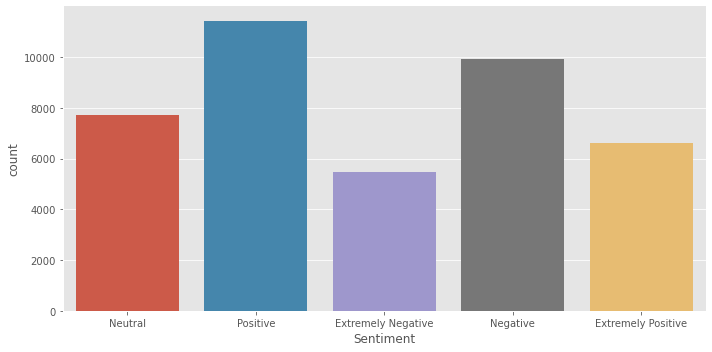

In [8]:
sns.catplot(x = 'Sentiment', kind = 'count', data = training, height = 5, aspect = 2)

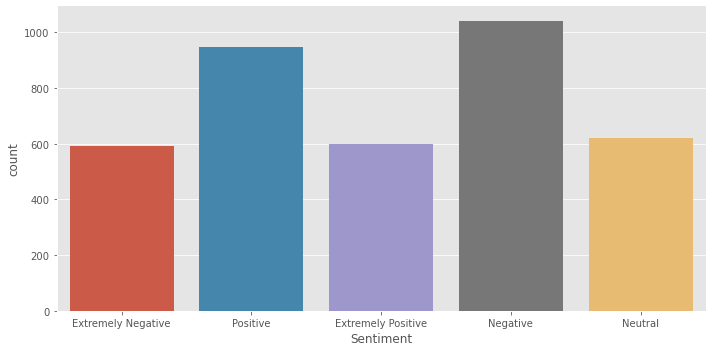

In [9]:
sns.catplot(x = 'Sentiment', kind = 'count', data = validation, height = 5, aspect = 2)

## III. Cleaning the Comments

In [9]:
training.rename({"OriginalTweet": "text", "Sentiment": "label"}, axis="columns", inplace=True)
validation.rename({"OriginalTweet": "text", "Sentiment": "label"}, axis="columns", inplace=True)

#### From 5 classes to 3

In [10]:
# Data has 5 classes, let's convert them to 3

def classes_def(x):
    '''
    Makes the label variable have 3 classes instead of 5
    '''
    
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"

training['label'] = training['label'].apply(lambda x:classes_def(x))
validation['label'] = validation['label'].apply(lambda x:classes_def(x))

training.label.value_counts(normalize= True)

2    0.438467
0    0.374128
1    0.187404
Name: label, dtype: float64

#### Remove useless characters

In [12]:
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
    
training["text"] = training['text'].apply(lambda x:remove_urls(x))
validation["text"] = validation['text'].apply(lambda x:remove_urls(x))

In [13]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

training['text'] = training['text'].apply(lambda x:remove_html(x))
validation['text'] = validation['text'].apply(lambda x:remove_html(x))

In [14]:
# Lower Casing

def lower(text):
    low_text = text.lower()
    return low_text

training['text'] = training['text'].apply(lambda x:lower(x))
validation['text'] = validation['text'].apply(lambda x:lower(x))

In [15]:
# Remove Numbers

def remove_num(text):
    remove = re.sub(r'\d+', '', text)
    return remove

training['text'] = training['text'].apply(lambda x:remove_num(x))
validation['text'] = validation['text'].apply(lambda x:remove_num(x))

In [16]:
# Remove Punctuation

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct

training['text'] = training['text'].apply(lambda x:punct_remove(x))
validation['text'] = validation['text'].apply(lambda x:punct_remove(x))

In [17]:
# Remove Stopwords

nltk.download('stopwords')
",".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

training['text'] = training['text'].apply(lambda x:remove_stopwords(x))
validation['text'] = validation['text'].apply(lambda x:remove_stopwords(x))

[nltk_data] Downloading package stopwords to C:\Users\Poste-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Remove Mentions "@"

def remove_mention(x):
    text = re.sub(r'@\w+','',x)
    return text

training['text'] = training['text'].apply(lambda x:remove_mention(x))
validation['text'] = validation['text'].apply(lambda x:remove_mention(x))

In [19]:
# Remove Hashtags

def remove_hash(x):
    text = re.sub(r'#\w+','',x)
    return text

training['text'] = training['text'].apply(lambda x:remove_hash(x))
validation['text'] = validation['text'].apply(lambda x:remove_hash(x))

In [20]:
#Remove extra white space left while removing stuff

def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove

training['text'] = training['text'].apply(lambda x:remove_space(x))
validation['text'] = validation['text'].apply(lambda x:remove_space(x))

In [21]:
more_stop_words = ['a', 'and', 'the', 'i', 'me', 'my', 'we', 'ours', 'he', 'his', 'her', 'what', 'am',
              'have', 'has', 'had', 'be', 'was', 'been', 'of', 'at', 'for', 'to', 'your', 'is']

def remove_more_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in more_stop_words])

training['text'] = training['text'].apply(lambda x:remove_more_stopwords(x))
validation['text'] = validation['text'].apply(lambda x:remove_more_stopwords(x))

In [22]:
# Bag of Words

def tokenize(text):
    text = text.split()
    return text

training['text'] = training['text'].apply(lambda x:tokenize(x))
validation['text'] = validation['text'].apply(lambda x:tokenize(x))

## IV. Bag of Words Representation

In [24]:
validation.shape

(3798, 2)

In [25]:
x_train = training['text']
y_train = training['label']

x_val = validation['text']
y_val = validation['label']

In [54]:
y_val_array = np.asarray(y_val.values).astype("float")
y_val_array

# RUN ONLY ONCE
# np.savetxt("data/y_val.txt.gz", y_val_array) # Save into a file / .gz compresses the file

array([0., 2., 2., ..., 1., 0., 2.])

In [64]:
y_train_array = np.asarray(y_train.values).astype("float")
y_train_array

# RUN ONLY ONCE
# np.savetxt("data/y_train.txt.gz", y_train_array) # Save into a file / .gz compresses the file

array([1., 2., 2., ..., 2., 1., 0.])

### A) Vocabulary

In [24]:
vocabulary = collections.Counter()
len_x_train = len(x_train)

for i in range(len_x_train):
    words = x_train[i]    
    vocabulary.update(words)

# RUN ONLY ONCE
    
# Save vocabulary in "lesser_vocabulary.txt" file
#f = open("data/lesser_vocabulary.txt", "w", encoding="utf-8")

#for word, count in vocabulary.most_common(1000): # 1000 most common words
#    print(word, file=f)
#f.close()

In [32]:
def load_vocabulary(filename):
    f = open(filename, encoding="utf-8")
    text = f.read()
    f.close()
    words = text.split()
    
    # Create index for each word
    voc = {}
    index = 0
    for word in words:
        voc[word] = index
        index += 1
    
    return voc

In [34]:
vocabulary = load_vocabulary("data/lesser_vocabulary.txt")
list(vocabulary.items())[:5]

[('covid', 0),
 ('coronavirus', 1),
 ('prices', 2),
 ('food', 3),
 ('supermarket', 4)]

### B) Comment as a BoW

#### Example of a BoW for the 3rd comment

In [34]:
x_train[2]

['coronavirus',
 'australia',
 'woolworths',
 'give',
 'elderly',
 'disabled',
 'dedicated',
 'shopping',
 'hours',
 'amid',
 'covid',
 'outbreak']

In [28]:
words = x_train[2]
    
bow = np.zeros(len(vocabulary))
for word in words:
    if word in vocabulary:
        index = vocabulary[word]
        bow[index] += 1

bow

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1.

In [35]:
def read_comment_bow(comment, voc):
    words = x_train[comment]
    
    # Bag of Words
    bow = np.zeros(len(voc))
    for word in words:
        if word in voc:
            index = voc[word]
            bow[index] += 1

    return bow

#### Training Data

In [30]:
comments = []

for i in range(len(x_train)):
    bow = read_comment_bow(comment=i, voc=vocabulary)
    
    comments.append(bow)

x_train_bow = np.stack(comments)

# RUN ONLY ONCE
# np.savetxt("data/lesser_x_train_bow.txt.gz", x_train_bow) # Save into a file / .gz compresses the file

#### Testing Data

In [37]:
val_comments = []

for i in range(len(x_val)):
    val_bow = read_comment_bow(comment=i, voc=vocabulary)
    
    val_comments.append(val_bow)

x_val_bow = np.stack(val_comments)

# RUN ONLY ONCE
# np.savetxt("data/lesser_x_val_bow.txt.gz", x_val_bow) # Save into a file / .gz compresses the file

#  NE PAS REGARDER LA SUITE

In [ ]:
print(training.shape)
#training = training[(training['text'].str.len() > 20)]
print(training.shape)

In [ ]:
x_train = training['text']
y_train = training['label']

x_val = validation['text']
y_val = validation['label']

#  QUOI

In [61]:
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(oov_token=oov_tok, num_words=6000)
tokenizer.word_index

{}

In [62]:
tokenizer = Tokenizer(oov_token=oov_tok, num_words=6000)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [ ]:
sequences = tokenizer.texts_to_sequences(training_sentences)
sequences

# FIN QUOI

In [ ]:
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'

x_train = training['text']
y_train = training['label']

x_val = validation['text']
y_val = validation['label']

tokenizer = Tokenizer(oov_token = oov_tok, num_words = 6000)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index) +1

sequences = tokenizer.texts_to_sequences(x_train)

train_labels = tokenizer.texts_to_sequences(y_train)

validation_sequences = tokenizer.texts_to_sequences(x_val)

In [ ]:
tokenizer.texts_to_sequences(x_train)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv1D(128, 5, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 1),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv1D(256, 5, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

In [ ]:
tokenizer.texts_to_matrix(x_train)

In [ ]:
history = model.fit(tokenizer.texts_to_matrix(x_train), tokenizer.texts_to_matrix(y_train))

In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Accuarcy')

In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length = max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(128, 5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(256, 5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(512, 5, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 4),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])
model_2.summary()